In [5]:
#libraries
import os #lets us interact with underlying operating system
import numpy as np #
from sklearn.linear_model import LinearRegression #if we want to use sklearn linear regression
import sklearn.preprocessing
#from scipy.stats import boxcox
import scipy
import statsmodels.api as sm
import statsmodels.stats.stattools as stattools
import statsmodels.tsa as tsa#import adfuller
import pandas as pd
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
training = pd.read_csv('./Dataset/full_coffee_prices_test.csv')

In [7]:
y,fitted_lambda= scipy.stats.boxcox(training['price'],lmbda = None)
training['box_cox'] = y
training['box_cox_diff'] = training['box_cox'] - training['box_cox'].shift(1)
training = training.dropna()

In [15]:
def reverse_to_price(series, differenced_series, l):
    y = series + differenced_series
    y = scipy.special.inv_boxcox(y, l)
    return(y)

In [8]:
#Initial baseline with just price
augmented_dicky_fuller = tsa.stattools.adfuller(training['price'][1:])
print('ADF Statistic: %f' % augmented_dicky_fuller[0])
print('p-value: %f' % augmented_dicky_fuller[1])
print('Critical Values:')
for key, value in augmented_dicky_fuller[4].items():
print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.156159
p-value: 0.222540
Critical Values:
	5%: -2.863
	10%: -2.568
	1%: -3.434


In [9]:
#With Box-Cox transform. This addresses normality, not stationarity. 
#But the closer we are to normality,the more confident we are of these tests
augmented_dicky_fuller = tsa.stattools.adfuller(training['box_cox'][1:])
print('ADF Statistic: %f' % augmented_dicky_fuller[0])
print('p-value: %f' % augmented_dicky_fuller[1])
print('Critical Values:')
for key, value in augmented_dicky_fuller[4].items():
print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.794588
p-value: 0.383152
Critical Values:
	5%: -2.863
	10%: -2.568
	1%: -3.434


In [10]:
#Lets start by testing for stationarity and autocorrelation to establish a baseline.
#We'll do the Box-Cox + first difference transformations we established previously
augmented_dicky_fuller = tsa.stattools.adfuller(training['box_cox_diff'][1:])
print('ADF Statistic: %f' % augmented_dicky_fuller[0])
print('p-value: %f' % augmented_dicky_fuller[1])
print('Critical Values:')
for key, value in augmented_dicky_fuller[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -22.649439
p-value: 0.000000
Critical Values:
	5%: -2.863
	10%: -2.568
	1%: -3.434


In [9]:
year_2019 = training[(training['week_days'] >= '2019-01-01') & (training['week_days'] < '2020-01-01')]
augmented_dicky_fuller = tsa.stattools.adfuller(year_2019['box_cox_diff'])
print('ADF Statistic: %f' % augmented_dicky_fuller[0])
print('p-value: %f' % augmented_dicky_fuller[1])
print('Critical Values:')
for key, value in augmented_dicky_fuller[4].items():
print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.398845
p-value: 0.000000
Critical Values:
	5%: -2.873
	10%: -2.573
	1%: -3.457


The **Augmented Dicky-Fuller** test is testing the null hypothesis that a unit root is present. The lower the p-value/more negative the ADF statistic is, the more confident we are there is not unit root. It is easy to think of unit root as whether a series will "recover". Say the true function is 𝑣𝑡=𝑐+𝑎1𝑣𝑡−1+𝜖𝑡−1, a1 is a root of the series. We can always break down processes into roots where each term is by itself. If a1 < 1, that implies over a large sample we expect the series to converge to c and recover-- hence stationary. But if a1 = 1, a unit root, we expect that any deviations in the previous value vt-1 will result in a divergence and no recovery, hence, nonstationary.

With just Box-Cox + first difference, it seems we've achieved stationarity. At this point, we don't really need to continue testing because it seems like this series is difference stationary and I(1) was sufficient. But in the future, we may want to try setting regression = 'ct' in the adfuller function to test of trend stationarity.

-----------
The next step, now that we've reached stationarity, is to deal with autocorrelation. Let's first test for autocorrelation. *1*) The most parameterized test is Durbin-Watson, where the null is the assumption of typical regression while the alternative is AR(1). In the middle is *2)* a semi-parametric plot with ACF plots. The final *3)* is non-parametric test the runs test

In [11]:
x = training['box_cox_diff'].shift(1)[1:]
y = training['box_cox_diff'][1:]

In [12]:
#Lets plot a basic OLS to get reisduals and perfrom DW test
model = sm.OLS(y, x).fit()
predictions = model.predict(x) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:           box_cox_diff   R-squared (uncentered):                   0.000
Model:                            OLS   Adj. R-squared (uncentered):             -0.000
Method:                 Least Squares   F-statistic:                             0.2520
Date:                Sun, 28 Jun 2020   Prob (F-statistic):                       0.616
Time:                        17:58:31   Log-Likelihood:                          13026.
No. Observations:                1807   AIC:                                 -2.605e+04
Df Residuals:                    1806   BIC:                                 -2.604e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
box_cox_diff    -0.0118      0.024     -0.502      0.616      -0.058       0.034
==============================================================================
Omnibus:                       54.774   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              132.695
Skew:                           0.081   Prob(JB):                     1.53e-29
Kurtosis:                       4.318   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

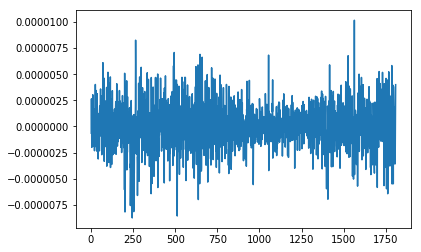

In [14]:
predictions.plot()

Durbin-Watson statistic will always vary between 0 and 4. When the statistic is close to 2, that means there is no autocorrelation detected (and we see 1.994) here. If it is close to 0, that suggest positive correlation. If it is close to 4, that suggest negative correlation.

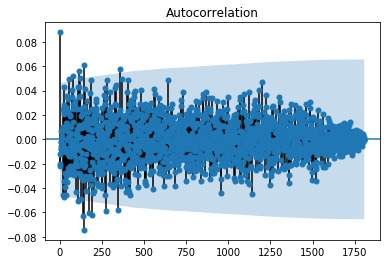

In [45]:
full_series = sm.graphics.tsa.plot_acf(training['box_cox_diff'], zero = False)

## AR, MA and ARIMA Models

In [4]:
ar_fit = tsa.ar_model.AutoReg(training['box_cox'], lags = 1).fit()
ar_fit.summary()

NameError: name 'training' is not defined

In [36]:
#MA(1) component is not statistically significant, so AR(1) is sufficient
arma_fit = tsa.arima_model.ARMA(training['box_cox'],order = (1,1)).fit()
arma_fit.summary()

//anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                box_cox   No. Observations:                 1808
Model:                     ARMA(1, 1)   Log Likelihood               13032.325
Method:                       css-mle   S.D. of innovations              0.000
Date:                Sun, 28 Jun 2020   AIC                         -26056.650
Time:                        14:02:04   BIC                         -26034.650
Sample:                             0   HQIC                        -26048.530
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.0556      0.001   1120.745      0.000       1.054       1.057
ar.L1.box_cox     0.9961      0.002    471.540      0.000       0.992       1.000
ma.L1.box_cox    -0.0099      0.024     -0.410      0.682      -0.057       0.037
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0039           +0.0000j            1.0039            0.0000
MA.1          101.2876           +0.0000j          101.2876            0.0000
-----------------------------------------------------------------------------
"""

In [37]:
#
arima_fit = tsa.arima_model.ARIMA(training['box_cox'],order = (1,1,1)).fit()
arima_fit.summary()

//anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
//anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:              D.box_cox   No. Observations:                 1807
Model:                 ARIMA(1, 1, 1)   Log Likelihood               13026.283
Method:                       css-mle   S.D. of innovations              0.000
Date:                Sun, 28 Jun 2020   AIC                         -26044.567
Time:                        14:03:19   BIC                         -26022.569
Sample:                             1   HQIC                        -26036.448
                                                                              
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -3.046e-06   4.16e-06     -0.732      0.464   -1.12e-05    5.11e-06
ar.L1.D.box_cox    -0.0060      0.534     -0.011      0.991      -1.053       1.041
ma.L1.D.box_cox    -0.0060      0.544     -0.011      0.991      -1.073       1.061
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1         -166.4853           +0.0000j          166.4853            0.5000
MA.1          166.1877           +0.0000j          166.1877            0.0000
-----------------------------------------------------------------------------
"""

In [ ]:
## Lets try our own auto-arima function

def objfunc(order, exog, endog):
    from statsmodels.tsa.arima_model import ARIMA
    fit = ARIMA(endog, order, exog).fit()
    return fit.aic()

from scipy.optimize import brute
grid = (slice(1, 3, 1), slice(1, 3, 1), slice(1, 3, 1))
brute(objfunc, grid, args=(exog, endog), finish=None)